# Complex Networks: TD1

------

__I always start my notebooks this way__

In [1]:
%reset -f
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

Importing useful packages

In [2]:
#My own code
from ShortestPath import *
#Compute faster
from itertools import combinations
#Visualization
import numpy as np
import pandas as pd
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
import time

### Here we define the Graph class asked

In [40]:
class Graph(object):
    def __init__(self, graph_dict=None):
        """ initializes a graph object """
        if graph_dict:
            self.__graph_dict = graph_dict
        else:
            self.__graph_dict = dict()


    def vertices(self):
        """ returns the vertices of a graph """
        return list(self.__graph_dict.keys())

    def edges(self):
        """ returns the edges of a graph """
        return self.__generate_edges()

    def add_vertex(self, vertex):
        """ If vertex is not in self.__graph_dict, a key "vertex" with an empty
        list as a value is added to the dictionary. Otherwise nothing has to be 
        done. To complete."""
        if  type(vertex) != str:
            print("It has to be a string")
            return False
        if not vertex in self.vertices():
            self.__graph_dict[vertex] = list() 

    def add_edge(self, edge):
        """ assumes that edge is of type set, tuple or list. No loops or 
        multiple edges. To complete."""
        for vertex in edge:
            if not vertex in self.vertices():
                print("One of these vertices is not in the Graph. Add it before")
                return False
        vertex1, vertex2 = edge
        self.__graph_dict[vertex1].append(vertex2)
        self.__graph_dict[vertex2].append(vertex1)
        
        
    def __generate_edges(self):
        """ A static method generating the edges of the graph "graph". Edges 
        are represented as sets two vertices, with no loops. To complete."""
        edges = []
        for vertice in list(self.__graph_dict.keys()):
            for vertice2 in self.__graph_dict[vertice]:
                if not set([vertice, vertice2]) in edges:
                    edges.append(set([vertice, vertice2]))
        
        return edges

    def vertex_degree(self):
        """returns degrees of each vertices, in a dict 
        """
        output = dict()
        for vertex in self.vertices():
            output[vertex] = len(self.__graph_dict[vertex])
        return output
    
    def find_isolated_vertices(self):
        """returns the list of the isolated vertices
        """
        vertex_degrees = self.vertex_degree()
        return [vertex for vertex in vertex_degrees.keys() if vertex_degrees[vertex] == 0]
    
    def density(self):
        """returns the density of the graph. It is a float number."""
        return 2 * len(self.edges()) / ((len(self.vertices()))*(len(self.vertices())-1))
    
    def degree_sequence(self):
        """It returns the non increasing list of degrees in the graph"""
        vertex_degrees = self.vertex_degree()
        return tuple(sorted([vertex_degrees[vertex] for vertex in vertex_degrees.keys()], reverse=True))
        

    def erdos_gallai(self,degree_sequence):
        """returns the boolean saying if the degree sequence corresponds to an actual graph"""
        length = len(degree_sequence)
        for k in range(1, length+1):
            
            sumLeft = sum(degree_sequence[:k])
            sumRight = k*(k-1) + sum([min(d,k) for d in degree_sequence[k:]])
            if sumLeft > sumRight:
                return False
        return True
    def global_clustering_coefficient(self):
        """returns the global clustering coefficient"""
        vertex_degrees = self.vertex_degree()
        number_of_connected_triplets_of_vertices = int(sum([vertex_degrees[vertex]*(vertex_degrees[vertex]-1)/2 for vertex in vertex_degrees.keys()]))
        closed_triplets = 0
        for vertexMaster in self.vertices():
            for vertexA, vertexB in combinations(self.__graph_dict[vertexMaster],2):
                closed_triplets += (vertexA in self.__graph_dict[vertexB]) and (vertexB in self.__graph_dict[vertexA])
        output = closed_triplets / number_of_connected_triplets_of_vertices
        if output > 1 or output < 0:
            print("Do not trust the output")
            return -1
        return output
        
    def shortestPath(self,debut,fin):
        
        try:
            return shortest(self.__graph_dict,debut,fin,[],{},{},debut)
        except:
            if debut == fin:
                return (0, [debut,fin])
            else:
                return (float("inf"), [])
        #return shortest(self.__graph_dict,debut,fin,[],{},{},debut)
    
    def diameter(self, mode="np"):
        vertices = self.vertices()
        keys = vertices
        values = [i for i in range(len(self.vertices()))]
        dictionary = dict(zip(keys, values))
        if mode=="np":
            output = np.empty((len(vertices),len(vertices),))
            output[:] = float("inf")
        
        for a in dictionary:
            output[dictionary[a]][dictionary[a]] = 0
        edges = self.edges()
        for a,b in edges:
            output[dictionary[a]][dictionary[b]] = 1
            output[dictionary[b]][dictionary[a]] = 1
        """
        for k,i,j in tqdm(zip(vertices,vertices,vertices)):
            if output[i][j] > output[i][k] + output[k][j]:
                output[i][j] = output[i][k] + output[k][j]
                """
        for k in tqdm(values):
            for i in values:
                for j in values:
                    if output[i][j] > output[i][k] + output[k][j]:
                        output[i][j] = output[i][k] + output[k][j]
        return output.max()
        
    
    def connectedComponents(self):
        vertices = self.vertices()
        checkedVertices = list()
        output = []
        
        for vertexMaster in vertices:
            if not vertexMaster in checkedVertices:
                component = [vertexMaster]
                for vertexSlave in vertices:
                    if self.shortestPath(vertexMaster, vertexSlave)[0] != float("inf"):
                        checkedVertices.append(vertexSlave)
                        component.append(vertexSlave)
                checkedVertices.append(vertexMaster)
                output.append(component)
        return output
    
    def connectedComponentsResume(self):
        cc = self.connectedComponents()
        return {"number": len(cc), "maxSize": max([len(c) for c in cc]), "minSize": min([len(c) for c in cc])}
                        
    def diameter_bis(self):
        vertices = self.vertices()
        #return max([self.dij_rec(vertexA,vertexB)[0] for vertexA, vertexB in combinations(vertices,2)])
        liste = []
        max_listes = []
        for vertexA, vertexB in tqdm(combinations(vertices,2)):
            add = True
            for path in max_listes:
                if vertexA in path and vertexB in path:
                    add = False
                    break
            if add:
                shortest = self.shortestPath(vertexA,vertexB)
                max_listes.append(shortest[1])
                liste.append(shortest[0])
        return max(liste)
            
    def biggestComponentDiameter(self):
        cc = self.connectedComponents()
        argmax = np.argmax([len(c) for c in cc])
        vertices = cc[argmax]
        return max([self.dij_rec(vertexA,vertexB)[0] for vertexA, vertexB in combinations(vertices,2)])
        
    def spanning_tree(self):
        output = Graph()
        visitedVertices = list()
        firstVertex = self.vertices()[0]
        output.add_vertex(firstVertex)
        visitedVertices.append(firstVertex)
        
        vertices = self.vertices()
        values = [0 for _ in range(len(vertices))]
        visited = dict(zip(keys, values))
 
        

--------------


## Testing on little data

Defining a basic graph, the one that will be tested

In [41]:
G={ "a": ["c", "d", "g"],
    "b": ["c", "f"],
    "c": ["a", "b", "d", "f"],
    "d": ["a", "c", "e", "g"],
    "e": ["d"],
    "f": ["b", "c"],
    "g": ["a", "d"]}
""",
    "x": ["y"],
    "y": ["x","z"],
    "z": ["y", "t"],
    "t": ["z"]
  }
"""
graph = Graph(G)

### 1. Building an elementary graph library

#### 1.a)

In [42]:
graph.edges()

[{'a', 'c'},
 {'a', 'd'},
 {'a', 'g'},
 {'b', 'c'},
 {'b', 'f'},
 {'c', 'd'},
 {'c', 'f'},
 {'d', 'e'},
 {'d', 'g'}]

#### 1.b)

In [6]:
#graph.add_vertex("addedVertex")

#### 1.c)

In [7]:
#graph.add_edge({"a","b"})

----
### 2. Methods related to degree

#### 2.1 Degree and isolated vertices
#### a)

In [8]:
graph.vertex_degree()

{'a': 3, 'b': 2, 'c': 4, 'd': 4, 'e': 1, 'f': 2, 'g': 2}

#### b)

In [9]:
graph.find_isolated_vertices()

[]

#### 2.2 Density calculation

In [10]:
graph.density()

0.42857142857142855

#### 2.3 Degree sequence

In [11]:
graph.degree_sequence()

(4, 4, 3, 2, 2, 2, 1)

#### 2.4 Erdoïs-Gallai theorem

In [12]:
graph.erdos_gallai(graph.degree_sequence())

True

#### 2.5 Clustering coefficient

In [13]:
graph.global_clustering_coefficient()

0.5

### 2. Methods related to graph traversal

#### 3.1 Connected components

In [14]:
print(graph.connectedComponents())
print("\n")
print(graph.connectedComponentsResume())

[['a', 'a', 'b', 'c', 'd', 'e', 'f', 'g']]


{'number': 1, 'maxSize': 8, 'minSize': 8}


#### 3.2 Shortest path

In [15]:
graph.shortestPath("a","b")

(2, ['a', 'c', 'b'])

#### 3.3 Diameter

In [16]:
graph.diameter()

100%|██████████| 7/7 [00:00<00:00, 6749.45it/s]


3.0

#### 3.4 Spanning tree

-----
**TO DO**

-----

### 4. Testing on real datasets

## Preprocessing

In [17]:
def to_set(x):
    return set(x)
    
def turnDataIntoGraphReady(path):
    df1 = pd.read_csv(path, sep='\t', names=["a","b"])
    df2 = pd.read_csv(path, sep='\t', names=["b","a"])
    df = df1.append(df2)
    df.reset_index(inplace=True)
    df.drop("index", axis=1, inplace=True)
    def to_set(x):
        return set(x)
    df = df.groupby('a')['b'].agg({'set': to_set})
    df["a"] = df.index
    d = [{str(y): [str(z) for z in x]} for x,y in df.values.tolist()]
    GA = {}
    for data in d:
        GA = {**GA, **data}
        #time.sleep(.01)
    return GA
    

Here are the paths of the data we want to test

In [18]:
paths = ["zachary_connected.txt","graph_100n_1000m.txt", "graph_1000n_4000m.txt"] 

In [19]:
columns = ["number of vertices","number of edges",
           "density","diameter","clustering coefficient"]
answer = pd.DataFrame(index=paths, columns=columns)

Here are the metrics asked

In [20]:
for path in paths:
    print("========================")
    print("Graph source is " + path[:-4])
    t = turnDataIntoGraphReady(path=path)
    g = Graph(t)
    #####
    nov = len(g.vertices())
    print("There are ", nov," vertices")
    answer["number of vertices"][path] = nov
    #####
    ed = len(g.edges())
    print("There are ", ed," edges")
    answer["number of edges"][path] = ed
    #####
    den = g.density()
    print("The density is ", den)
    answer["density"][path] = den
    #####
    coef = g.global_clustering_coefficient()
    print("The global clustering coefficient is ", coef)
    answer["clustering coefficient"][path] = coef
    #####
    diam = g.diameter()
    print("The diameter is ", diam)
    answer["diameter"][path] = diam
    print("\n")
    


100%|██████████| 33/33 [00:00<00:00, 873.16it/s]

Graph source is zachary_connected
There are  33  vertices
There are  78  edges
The density is  0.14772727272727273
The global clustering coefficient is  0.15458015267175573
The diameter is  5.0


Graph source is graph_100n_1000m
There are  100  vertices
There are  960  edges
The density is  


  0%|          | 0/100 [00:00<?, ?it/s]

0.19393939393939394
The global clustering coefficient is  0.19275720164609053


100%|██████████| 100/100 [00:00<00:00, 101.65it/s]


The diameter is  3.0


Graph source is graph_1000n_4000m
There are  1000  vertices
There are  3989  edges
The density is  0.007985985985985987
The global clustering coefficient is  0.006997856512419619


100%|██████████| 1000/1000 [15:50<00:00,  1.09it/s]

The diameter is  6.0




# Testing with a full library
Networkxx
https://github.com/networkx

In [26]:
networkXXanswer = pd.DataFrame(index=paths, columns=columns)

In [31]:
import networkx as nx
for path in paths:
    print("Graph source is " + path[:-4])
    g = nx.read_adjlist(path)
    print("There are ", g.number_of_nodes()," vertices")
    networkXXanswer["number of vertices"][path] = g.number_of_nodes()
    print("There are ", g.number_of_edges()," edges")
    networkXXanswer["number of edges"][path] = g.number_of_edges()
    print("The density is ", nx.density(g))
    networkXXanswer["density"][path] = nx.density(g)
    print("The global clustering coefficient is ", nx.average_clustering(g))
    networkXXanswer["clustering coefficient"][path] = nx.average_clustering(g)
    print("The diameter is ", nx.diameter(g))
    networkXXanswer["diameter"][path] = nx.diameter(g)
    print("\n")

Graph source is zachary_connected
There are  33  vertices
There are  78  edges
The density is  0.14772727272727273
The global clustering coefficient is  0.2301499203905621
The diameter is  5


Graph source is graph_100n_1000m
There are  100  vertices
There are  960  edges
The density is  0.19393939393939394
The global clustering coefficient is  0.1938186184178089
The diameter is  3


Graph source is graph_1000n_4000m
There are  1000  vertices
There are  3989  edges
The density is  0.007985985985985987
The global clustering coefficient is  0.00733904543169248
The diameter is  6




My answer is :

In [32]:
answer

,number of vertices,number of edges,density,diameter,clustering coefficient
zachary_connected.txt,33,78,0.147727,5,0.15458
graph_100n_1000m.txt,100,960,0.193939,3,0.192757
graph_1000n_4000m.txt,1000,3989,0.00798599,6,0.00699786


The Networkxx library answer is :

In [33]:
networkXXanswer

,number of vertices,number of edges,density,diameter,clustering coefficient
zachary_connected.txt,33,78,0.147727,5,0.23015
graph_100n_1000m.txt,100,960,0.193939,3,0.193819
graph_1000n_4000m.txt,1000,3989,0.00798599,6,0.00733905


##### Some vizualisation is always nice :

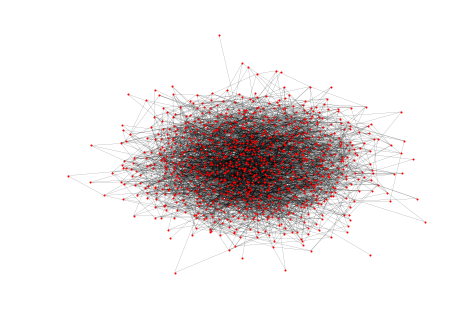

In [34]:
from matplotlib import pyplot as plt
#pos=nx.spring_layout(g)
nx.draw(g,node_size=1, width=.1)
#nx.draw_networkx(g,node_size=1)
plt.show()
plt.close()